In [1]:
from __future__ import division

from pulp import *
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import pandas as pd
import csv
import datetime
import sqlite3
import math
import glob

import seaborn as sns
%matplotlib inline

from pandas import *
from scipy import optimize
from scipy import stats
from datetime import date, timedelta
import timeit


from IPython.display import clear_output
from IPython.display import HTML
from matplotlib.ticker import MultipleLocator

## Meter data at ALCOPARK

## Read the utility rate structure of E19, PGE

In [4]:
# consider the holidays
holidays = pd.read_csv('../../holiday.csv', usecols=[0])
holidays['date'] = pd.to_datetime(pd.Series(holidays['date']), format='%m/%d/%y')
holidays['day'] = holidays.date.apply(lambda x: x.strftime('%Y-%m-%d'))

# utility tariff, E19-TOU
utility = []
utility = pd.read_csv('../../PGE_E19.csv', usecols=[1])

# meter charge
meter_charge = float("{0:.2f}".format(utility['Secondary'][0]))
# demand charge
summer_onpeak_demand = utility['Secondary'][1]
summer_midpeak_demand = utility['Secondary'][2]
summer_monthly_demand = utility['Secondary'][3]
winter_midpeak_demand = utility['Secondary'][4]
winter_monthly_demand = utility['Secondary'][5]

# energy charge
summer_onpeak_energy = utility['Secondary'][6]
summer_midpeak_energy = utility['Secondary'][7]
summer_offpeak_energy = utility['Secondary'][8]
winter_midpeak_energy = utility['Secondary'][9]
winter_offpeak_energy = utility['Secondary'][10]

# PDP charge and credits
cpp_charge = utility['Secondary'][11]
credits_onpeak_demand = utility['Secondary'][12]
credits_midpeak_demand = utility['Secondary'][13]
# credits_onpeak_energy = utility['Secondary'][14]
# credits_midpeak_energy = utility['Secondary'][15]

# Read original Nonfleet EVs and Optimized EVs 

In [126]:
# ev_power = pd.DataFrame([])
# index = pd.date_range('2016-01-01 00:00', '2016-12-31 23:45', freq='15min')
# ev_power = pd.DataFrame(index=index)

ev_power = pd.DataFrame()
for mon in range(1,13,1):
    ev = pd.read_csv('results/FlexDrivers/NewEVStatus/Opt2016/2016-' +str(mon)+'.csv')
    ev.index = ev.ix[:,0].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
    ev.drop(ev.columns[[0]], axis=1, inplace=True)
    ev.index.name = 'time'
    ev['power'] = ev.sum(axis = 1)
    
    ev_power = pd.concat([ev_power,pd.DataFrame(ev['power'])], axis=0)

In [133]:
ev_power.loc[ev_power.power < 0] = 0

In [7]:
alcoMeter = pd.read_csv('../../sqldata/AlcoMeter2017.csv', delimiter=',', skiprows=range(12))
alcoMeter.index = alcoMeter.ix[:,0].apply(lambda x: datetime.strptime(x,'%m/%d/%y %H:%M'))
alcoMeter.drop(alcoMeter.columns[[0]], axis=1, inplace=True)
alcoMeter.index.name = 'time'
alcoMeter.columns=['building']

alcopark = pd.concat([ev_power,alcoMeter], axis=1, join_axes=[ev_power.index])
alcopark.columns=['evpower','building']
alcopark.index.name = 'time'

In [103]:
# alcopark = pd.read_csv('results/FlexDrivers/NewEVStatus/alcopark/' + '2015-EVPower.csv')
# alcopark.index = alcopark.ix[:,0].apply(lambda x: datetime.strptime(x,'%m/%d/%y %H:%M'))
# alcopark.drop(alcopark.columns[[0]], axis=1, inplace=True)
# alcopark.index.name = 'time'

# alcopark['evpower'] = EV.power.values
alcopark = alcoMeter.copy()

alcopark['day'] = list(map(lambda x: x.strftime('%Y-%m-%d'),alcopark.index))
alcopark['weekday'] = alcopark.index.weekday
alcopark['hour'] = alcopark.index.hour
alcopark['Date']=alcopark.index
alcopark['time'] = alcopark.Date.apply(lambda x: x.strftime('%H:%M'))
alcopark['month'] = alcopark.index.month

# alcopark['basepower'] = alcopark.building - alcopark.evpower
alcopark['hour'] = alcopark.hour.astype(int)
alcopark['month'] = alcopark.month.astype(int)
alcopark['holiday'] = alcopark.Date.apply(lambda x: x.strftime('%Y-%m-%d') in holidays.day.values)
alcopark['holiday'] = alcopark.holiday.astype(int)
alcopark['PeakPeriod'] = 0

alcopark.loc[alcopark['holiday']==1,'weekday'] = -1

alcopark.loc[(alcopark.month >= 5) & (alcopark.month <= 10) & \
             (alcopark.weekday >= 0) & (alcopark.weekday <= 4) & \
             (alcopark.time >= '08:30') & (alcopark.time < '12:00'),'PeakPeriod'] = 1
alcopark.loc[(alcopark.month >= 5) & (alcopark.month <= 10) & \
             (alcopark.weekday >= 0) & (alcopark.weekday <= 4) & \
             (alcopark.time >= '12:00') & (alcopark.time < '18:00'),'PeakPeriod'] = 2
alcopark.loc[(alcopark.month >= 5) & (alcopark.month <= 10) & \
             (alcopark.weekday >= 0) & (alcopark.weekday <= 4) & \
             (alcopark.time >= '18:00') & (alcopark.time <= '21:30'),'PeakPeriod'] = 3

alcopark.loc[(alcopark.month.apply(lambda x: (x in [1,2,3,4,11,12]))) & \
             (alcopark.weekday >= 0) & (alcopark.weekday <= 4) & \
             (alcopark.time >= '08:30') & (alcopark.time <= '21:30'),'PeakPeriod'] = 1

In [104]:
mons = ['void','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

In [33]:
def alcopark_power(alcopark, month):
    df_wd = alcopark.loc[(alcopark['month']==month) & (alcopark['weekday'] >= 0) & (alcopark['weekday'] <= 4)]
    df_wk = alcopark.loc[(alcopark['month']==month) & (alcopark.weekday.apply(lambda x: (x in [5,6])))]

    df_bldg_wd = df_wd.pivot(index='time',columns='day',values='building')
#     df_base_wd = df_wd.pivot(index='time',columns='day',values='basepower')
#     df_ev_wd = df_wd.pivot(index='time',columns='day',values='evpower')

    df_bldg_wk = df_wk.pivot(index='time',columns='day',values='building')
#     df_base_wk = df_wk.pivot(index='time',columns='day',values='basepower')

    fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=True, sharex=False)
    fig.subplots_adjust(hspace = .1, wspace=.05)

    df_bldg_wd.plot(ax=axes[0],c='gray',alpha=0.8)
    df_bldg_wd.mean(axis=1).plot(c='b',label='Average Meter Power', ax = axes[0])
#     axes[0,0].plot(df_bldg_wd.mean(axis=1),c='b',label='Average Meter Power')
    axes[0].set_ylabel('Power, [kW]')
    axes[0].set_xlabel('Hour of Day')
    axes[0].set_title('Whole Building Power on Weekdays in '+mons[month]+' 2017')
    axes[0].legend().set_visible(False)
#     axes[0,0].legend((['Daily Meter Power','Averaged Meter Power']))
    axes[0].axhline(y=13, xmin=0.1, xmax=0.2, c='b',linewidth=2)
    axes[0].axhline(y=23, xmin=0.1, xmax=0.2, c='gray',linewidth=2)
    axes[0].text(20,20,'Daily Meter Power',fontsize=10)
    axes[0].text(20,10,'Averaged Daily Meter Power',fontsize=10)
    
    df_wd = alcopark.loc[(alcopark['month']==month)]
    df_peaks = df_wd.pivot(index='Date',columns='PeakPeriod',values='building')

    df_peaks.boxplot(ax=axes[1])
    axes[1].set_ylabel('Power, [kW]')
    axes[1].set_title('Peak Power Distribution in '+mons[month]+' 2017')
    axes[1].set_xticklabels(['Off-Peak','Mid-Peak','On-Peak','Mid-Peak'])
    axes[1].set_ylim(0,120)
    
#     df_base_wd.plot(ax=axes[0,1],c='gray',alpha=0.8)
#     df_base_wd.mean(axis=1).plot(c='red',label='Average Base Power', ax = axes[0,1])
# #     axes[0,1].plot(df_base_wd.mean(axis=1),c='red', label='Average Base Power')
#     axes[0,1].set_ylabel('Power, [kW]')
#     axes[0,1].set_xlabel('Hour of Day')
#     axes[0,1].set_title('Base Power without EVs on Weekdays in '+mons[month]+' 2016')
#     axes[0,1].legend().set_visible(False)
#     axes[0,1].axhline(y=30, xmin=0.35, xmax=0.45, c='red',linewidth=4)
#     axes[0,1].axhline(y=40, xmin=0.35, xmax=0.45, c='gray',linewidth=4)
#     axes[0,1].text(45,38,'Daily Base Power',fontsize=14)
#     axes[0,1].text(45,28,'Averaged Daily Base Power',fontsize=14)

#     df_ev_wd.plot(ax=axes[1,0],c='gray',alpha=0.8)
#     df_ev_wd.mean(axis=1).plot(c='g', ax = axes[1,0])
# #     axes[1,0].plot(df_ev_wd.mean(axis=1),color='g')
#     axes[1,0].set_ylabel('Power, [kW]')
#     axes[1,0].set_xlabel('Hour of Day')
#     axes[1,0].set_title('EVs Power on Weekdays in '+mons[month]+' 2016')
#     axes[1,0].legend().set_visible(False)
#     axes[1,0].axhline(y=80, xmin=0.35, xmax=0.45, c='g',linewidth=4)
#     axes[1,0].axhline(y=90, xmin=0.35, xmax=0.45, c='gray',linewidth=4)
#     axes[1,0].text(45,88,'Daily EVs Power',fontsize=14)
#     axes[1,0].text(45,78,'Averaged Daily EVs Power',fontsize=14)

#     # df_base_wk.plot(ax=axes[1,1],color='gray',alpha=0.8)
#     df_bldg_wd.mean(axis=1).plot(c='b', label='Meter Power', ax = axes[1,1])
#     df_base_wd.mean(axis=1).plot(c='r', label='Base Power', ax = axes[1,1])
# #     axes[1,1].plot(df_bldg_wd.mean(axis=1),c='b',label='Meter Power')
# #     axes[1,1].plot(df_base_wd.mean(axis=1),c='r',label='Base Power')

#     axes[1,1].set_ylabel('Power, [kW]')
#     axes[1,1].set_xlabel('Hour of Day')
#     axes[1,1].set_title('Base Power, EVs on Weekdays in '+mons[month]+' 2016')
#     axes[1,1].legend()
#     axes[1,1].fill_between(range(len(df_base_wd.mean(axis=1))), df_base_wd.mean(axis=1), df_bldg_wd.mean(axis=1), facecolor='gray')

    fig.savefig('../../results/2017/Alcopark-2017-'+str(month)+'.png', dpi=300, format='png',bbox_inches='tight')

/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


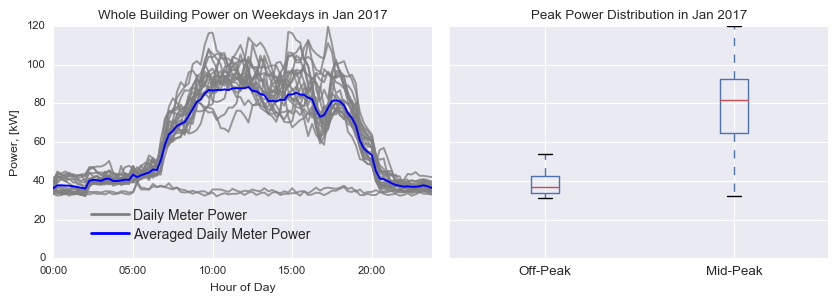

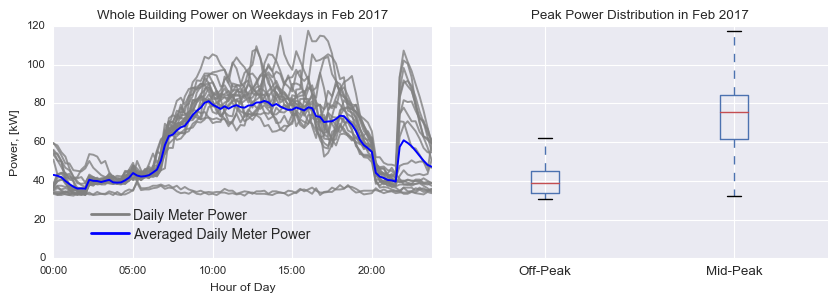

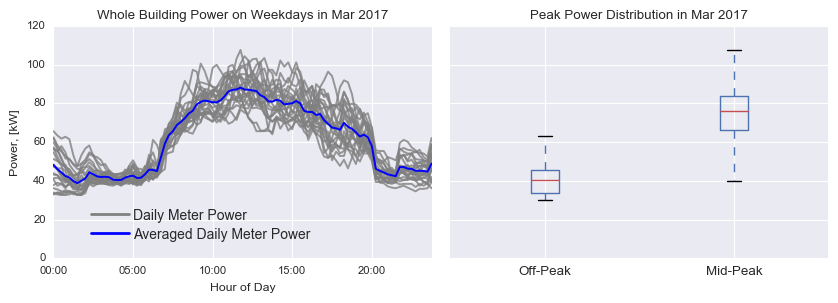

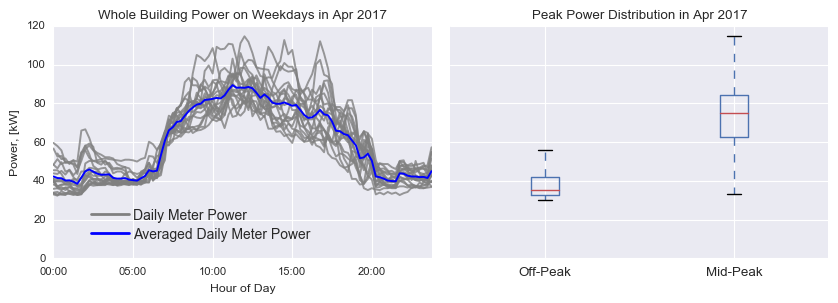

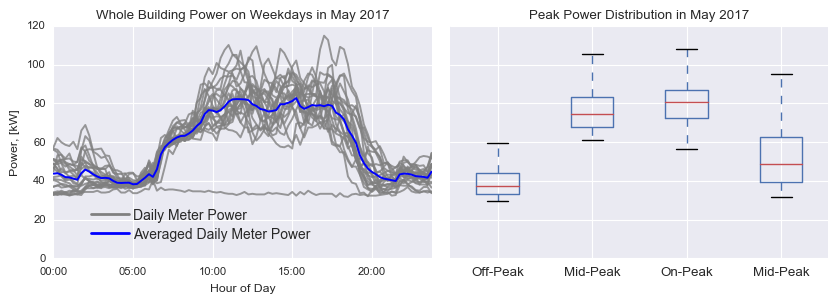

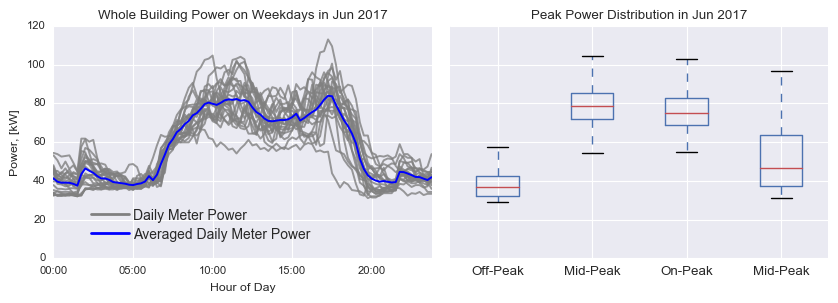

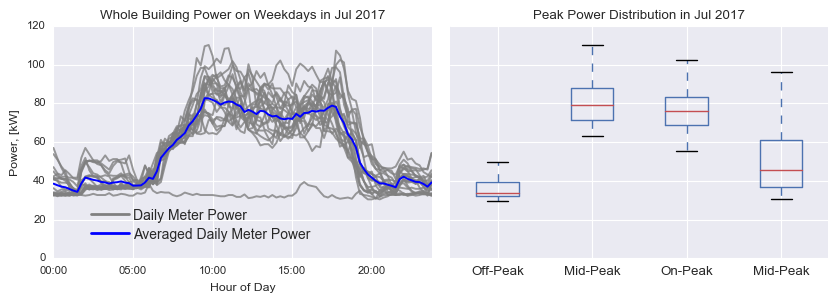

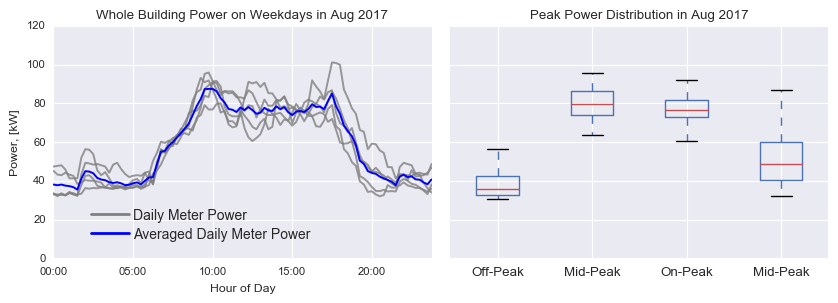

In [35]:
sns.set_context('paper')
for mon in range(8):
    alcopark_power(alcopark, mon+1)


# Peak load, load variability

In [29]:
month=1
df_wd = alcopark.loc[(alcopark['month']==month) & (alcopark['weekday'] >= 0) & (alcopark['weekday'] <= 4)]
df_wk = alcopark.loc[(alcopark['month']==month) & (alcopark.weekday.apply(lambda x: (x in [5,6])))]

df_bldg_wd = df_wd.pivot(index='time',columns='day',values='building')
df_base_wd = df_wd.pivot(index='time',columns='day',values='basepower')
df_ev_wd = df_wd.pivot(index='time',columns='day',values='power')

df_bldg_wk = df_wk.pivot(index='time',columns='day',values='building')
df_base_wk = df_wk.pivot(index='time',columns='day',values='basepower')

## Double-check load flexibility for each charging event. 

/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:44: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:45: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


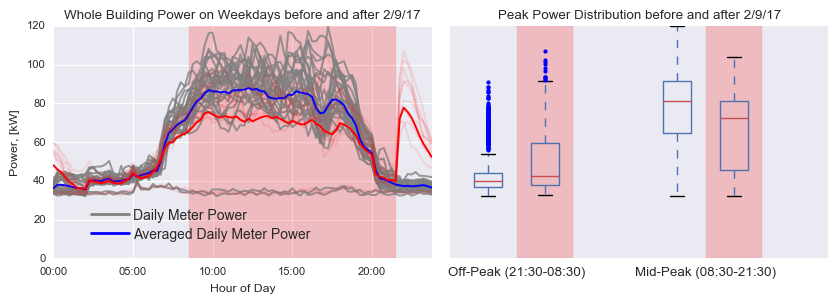

In [150]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker

data = alcopark['2017-01-01':'2017-02-09']
data2 = alcopark['2017-02-10':'2017-02-25'].dropna(subset=['building'], how='any')
df_wd = data.loc[(data['weekday'] >= 0) & (data['weekday'] <= 4)]
df_wk = data.loc[(data.weekday.apply(lambda x: (x in [5,6])))]
df_wd2 = data2.loc[(data2['weekday'] >= 0) & (data2['weekday'] <= 4)]
df_bldg_wd = df_wd.pivot(index='time',columns='day',values='building')
df_bldg_wk = df_wk.pivot(index='time',columns='day',values='building')

df_bldg_wd2 = df_wd2.pivot(index='time',columns='day',values='building')

fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=True, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.05)

df_bldg_wd.plot(ax=axes[0],c='gray',alpha=0.8)
df_bldg_wd.mean(axis=1).plot(c='b',label='Average Meter Power', ax=axes[0])

df_bldg_wd2.plot(ax=axes[0],c='r',alpha=0.1)
axes[0].plot(df_bldg_wd2.mean(axis=1).values, c='r')
# df_bldg_wd2.mean(axis=1).plot(c='r',label='Average Meter Power', ax=axes[0])

axes[0].set_ylabel('Power, [kW]')
axes[0].set_xlabel('Hour of Day')
axes[0].set_title('Whole Building Power on Weekdays before and after 2/9/17')
axes[0].legend().set_visible(False)
#     axes[0,0].legend((['Daily Meter Power','Averaged Meter Power']))
axes[0].axhline(y=13, xmin=0.1, xmax=0.2, c='b',linewidth=2)
axes[0].axhline(y=23, xmin=0.1, xmax=0.2, c='gray',linewidth=2)
axes[0].text(20,20,'Daily Meter Power',fontsize=10)
axes[0].text(20,10,'Averaged Daily Meter Power',fontsize=10)
# axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].axvspan(34,86, color='red', alpha=0.2)



# df_wd = alcopark.loc[(alcopark['month']==month)]
df_peaks = df_wd.pivot(index='Date',columns='PeakPeriod',values='building')
df_peaks2 = df_wd2.pivot(index='Date',columns='PeakPeriod',values='building')

# sns.boxplot(df_peaks,ax=axes[1],sym='k*')
# sns.boxplot(df_peaks2,ax=axes[1],sym='k*')
df_peaks.boxplot(positions = [0.85, 1.85],ax=axes[1],sym='k.')
df_peaks2.boxplot(positions = [1.15, 2.15],ax=axes[1],sym='k.')
axes[1].set_xticks([1, 2])
axes[1].set_ylabel('Power, [kW]')
axes[1].set_title('Peak Power Distribution before and after 2/9/17')
axes[1].set_xticklabels(['Off-Peak (21:30-08:30)','Mid-Peak (08:30-21:30)','On-Peak','Mid-Peak'])
axes[1].set_ylim(0,120)
axes[1].grid(False)
axes[1].axvspan(1,1.3, color='red', alpha=0.2)
axes[1].axvspan(2,2.3, color='red', alpha=0.2)

fig.savefig('../../results/2017/Alcopark-2017-1stFleetSet.png', dpi=300, format='png',bbox_inches='tight')

/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:44: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.
/Users/ryin/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:45: FutureWarning: 
The default value for 'return_type' will change to 'axes' in a future release.
 To use the future behavior now, set return_type='axes'.
 To keep the previous behavior and silence this warning, set return_type='dict'.


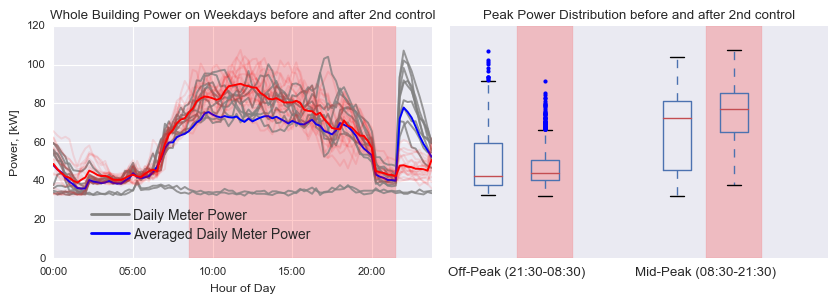

In [154]:
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
import matplotlib.ticker as ticker

data = alcopark['2017-02-10':'2017-02-25']
data2 = alcopark['2017-02-25':'2017-03-25'].dropna(subset=['building'], how='any')
df_wd = data.loc[(data['weekday'] >= 0) & (data['weekday'] <= 4)]
df_wk = data.loc[(data.weekday.apply(lambda x: (x in [5,6])))]
df_wd2 = data2.loc[(data2['weekday'] >= 0) & (data2['weekday'] <= 4)]
df_bldg_wd = df_wd.pivot(index='time',columns='day',values='building')
df_bldg_wk = df_wk.pivot(index='time',columns='day',values='building')

df_bldg_wd2 = df_wd2.pivot(index='time',columns='day',values='building')

fig, (axes) = plt.subplots(1,2, figsize=(10, 3), facecolor='w', edgecolor='k', sharey=True, sharex=False)
fig.subplots_adjust(hspace = .1, wspace=.05)

df_bldg_wd.plot(ax=axes[0],c='gray',alpha=0.8)
df_bldg_wd.mean(axis=1).plot(c='b',label='Average Meter Power', ax=axes[0])

df_bldg_wd2.plot(ax=axes[0],c='r',alpha=0.1)
axes[0].plot(df_bldg_wd2.mean(axis=1).values, c='r')
# df_bldg_wd2.mean(axis=1).plot(c='r',label='Average Meter Power', ax=axes[0])

axes[0].set_ylabel('Power, [kW]')
axes[0].set_xlabel('Hour of Day')
axes[0].set_title('Whole Building Power on Weekdays before and after 2nd control')
axes[0].legend().set_visible(False)
#     axes[0,0].legend((['Daily Meter Power','Averaged Meter Power']))
axes[0].axhline(y=13, xmin=0.1, xmax=0.2, c='b',linewidth=2)
axes[0].axhline(y=23, xmin=0.1, xmax=0.2, c='gray',linewidth=2)
axes[0].text(20,20,'Daily Meter Power',fontsize=10)
axes[0].text(20,10,'Averaged Daily Meter Power',fontsize=10)
# axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
axes[0].axvspan(34,86, color='red', alpha=0.2)



# df_wd = alcopark.loc[(alcopark['month']==month)]
df_peaks = df_wd.pivot(index='Date',columns='PeakPeriod',values='building')
df_peaks2 = df_wd2.pivot(index='Date',columns='PeakPeriod',values='building')

# sns.boxplot(df_peaks,ax=axes[1],sym='k*')
# sns.boxplot(df_peaks2,ax=axes[1],sym='k*')
df_peaks.boxplot(positions = [0.85, 1.85],ax=axes[1],sym='k.')
df_peaks2.boxplot(positions = [1.15, 2.15],ax=axes[1],sym='k.')
axes[1].set_xticks([1, 2])
axes[1].set_ylabel('Power, [kW]')
axes[1].set_title('Peak Power Distribution before and after 2nd control')
axes[1].set_xticklabels(['Off-Peak (21:30-08:30)','Mid-Peak (08:30-21:30)','On-Peak','Mid-Peak'])
axes[1].set_ylim(0,120)
axes[1].grid(False)
axes[1].axvspan(1,1.3, color='red', alpha=0.2)
axes[1].axvspan(2,2.3, color='red', alpha=0.2)

fig.savefig('../../results/2017/Alcopark-2017-2ndFleetSet.png', dpi=300, format='png',bbox_inches='tight')

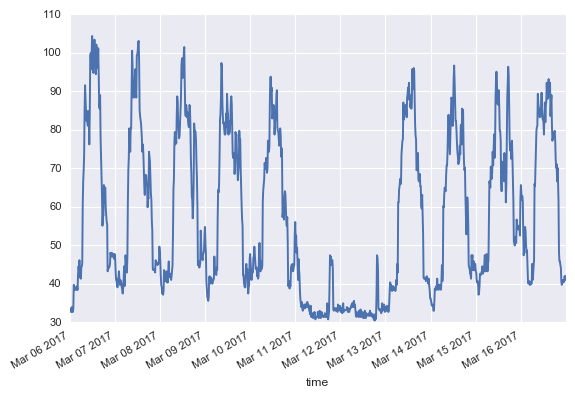

In [158]:
data2['2017-03-06':'2017-03-16']['building'].plot()